# Trabalho 4 - Data Mining

In [72]:
# Importar bibliotecas necessárias
import requests
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.neighbors import NearestNeighbors

### Baixar dados localmente

In [31]:
def download_data():
    url_zip = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'

    with requests.get(url_zip, stream=True) as r:
        r.raise_for_status()
        with open('data/ml-1m.zip', 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    # extrair o arquivo
    with zipfile.ZipFile('data/ml-1m.zip', 'r') as zip_ref:
        zip_ref.extractall('data/.')

In [32]:
# download_data()
ratings_file = 'data/ml-1m/ratings.dat'
movies_file = 'data/ml-1m/movies.dat'
ratings_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies_columns = ['MovieID', 'Title', 'Genres']

ratings = pd.read_csv(ratings_file, sep='::', header=None, names=ratings_columns, engine='python', encoding='ISO-8859-1')
movies = pd.read_csv(movies_file, sep='::', header=None, names=movies_columns, engine='python', encoding='ISO-8859-1')

## Análise Exploratória dos Dados

Temos 3883 filmes. 6040 usuários. 1000209 avaliações.

Filmes de 81 anos diferentes - entre 1919 e 2000.

Foi criada uma coluna numérica para o ano de cada filme e também sua década.

Foram avaliados 3706 filmes.
 

In [33]:
len(movies), len(ratings.UserID.unique()), len(ratings)

(3883, 6040, 1000209)

In [34]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [35]:
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)')
movies['Year'] = movies['Year'].astype(int)
movies['Title'] = movies['Title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

In [36]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [37]:
len(movies.Year.unique()), movies.Year.unique(), min(movies.Year), max(movies.Year)

(81,
 array([1995, 1994, 1996, 1976, 1993, 1992, 1988, 1967, 1964, 1977, 1965,
        1982, 1962, 1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973, 1970,
        1960, 1955, 1956, 1959, 1968, 1980, 1975, 1986, 1948, 1943, 1963,
        1950, 1946, 1987, 1997, 1974, 1958, 1949, 1972, 1998, 1933, 1952,
        1951, 1957, 1961, 1954, 1934, 1944, 1942, 1941, 1953, 1939, 1947,
        1945, 1938, 1935, 1936, 1926, 1932, 1930, 1971, 1979, 1966, 1978,
        1985, 1983, 1984, 1931, 1922, 1927, 1929, 1928, 1925, 1923, 1999,
        1919, 2000, 1920, 1921]),
 1919,
 2000)

In [38]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [39]:
ratings.MovieID.nunique()

3706

### Gráficos

Podemos ver que entre as decádas de 80, 90 e 2000 foram onde temos mais lançamentos de filmes. As demais possuem uma quantidade bem abaixo comparativamente. 

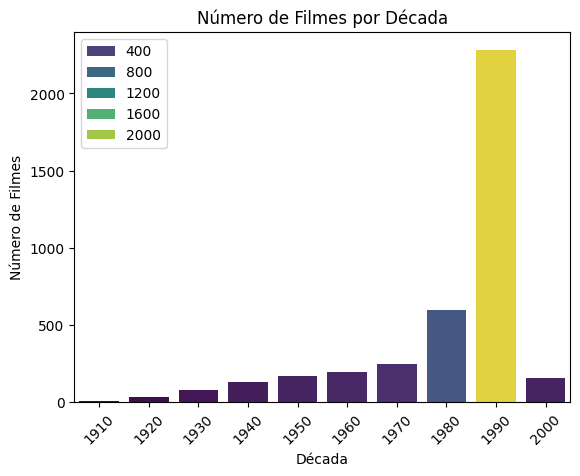

In [40]:
movies['Decade'] = (movies['Year'] // 10) * 10
movies_per_decade = movies['Decade'].value_counts().sort_index()

sns.barplot(x=movies_per_decade.index, y=movies_per_decade.values, hue=movies_per_decade.values, palette="viridis")
plt.title('Número de Filmes por Década')
plt.xlabel('Década')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.show()

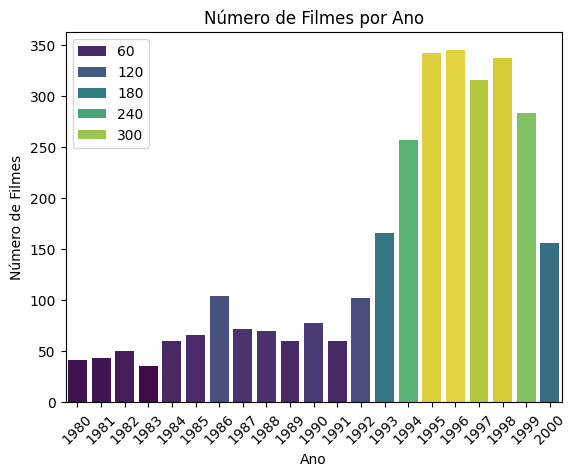

In [41]:
# Analisar filmes por ano a partir da década de 80
movies_per_year = movies[movies['Year'] >= 1980]['Year'].value_counts().sort_index()

sns.barplot(x=movies_per_year.index, y=movies_per_year.values, hue=movies_per_year.values, palette="viridis")
plt.title('Número de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.show()

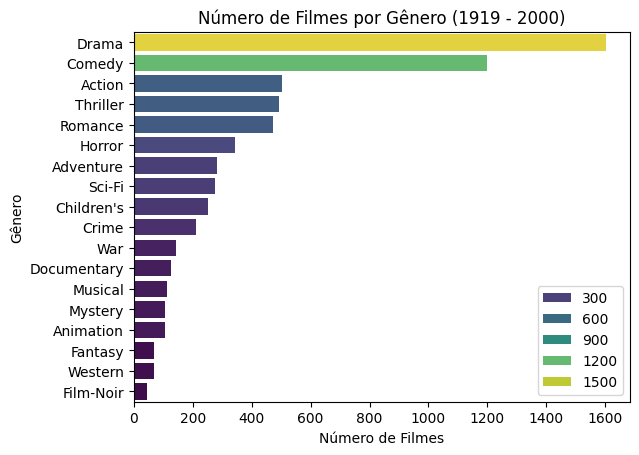

In [42]:
genres = movies['Genres'].str.get_dummies(sep='|')
genre_counts = genres.sum().sort_values(ascending=False)
sns.barplot(y=genre_counts.index, x=genre_counts.values, hue=genre_counts.values, palette="viridis")
plt.title('Número de Filmes por Gênero (1919 - 2000)')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

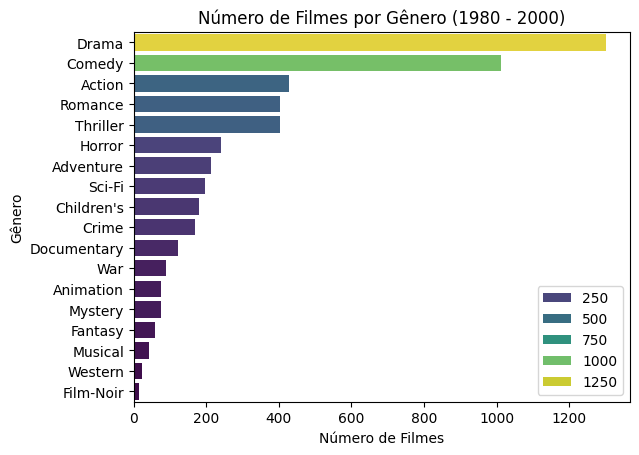

In [43]:
genres = movies[movies['Year'] >= 1980]['Genres'].str.get_dummies(sep='|')
genre_counts = genres.sum().sort_values(ascending=False)
sns.barplot(y=genre_counts.index, x=genre_counts.values, hue=genre_counts.values, palette="viridis")
plt.title('Número de Filmes por Gênero (1980 - 2000)')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

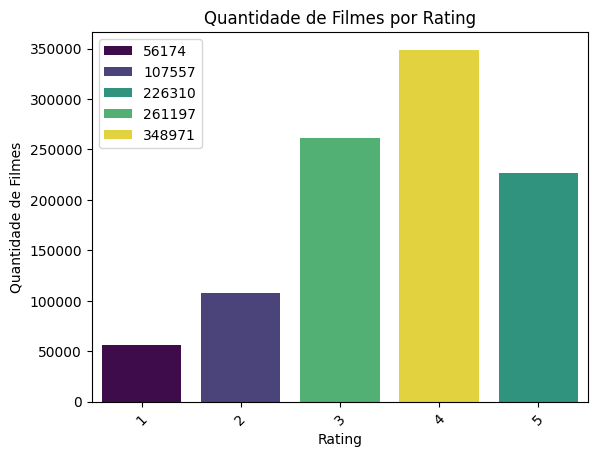

In [44]:
rating_counts = ratings['Rating'].value_counts().sort_index()

sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.values, palette="viridis")
plt.title('Quantidade de Filmes por Rating')
plt.xlabel('Rating')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=45)
plt.show()

## Pré-processamento dos dados

Não temos nenhum filme duplicado. Temos filmes relançados, com o mesmo título mas alguns anos de diferença. 

Coluna de gênero agora é um array contendo os gêneros.

Pegar o DataFrame de ratings e calcular uma média entre as avaliações dos usuários pelo ID do filme. Associar aos filmes, no DataFrame de movies, e excluir os filmes que não tiverem avaliação.

In [45]:
movies_duplicates = movies.duplicated().sum()
ratings_duplicates = ratings.duplicated().sum()
print(f'Filmes duplicados: {movies_duplicates}')
print(f'Avaliações duplicadas: {ratings_duplicates}')

Filmes duplicados: 0
Avaliações duplicadas: 0


In [46]:
movies['Genres'] = movies['Genres'].str.split('|')

In [47]:
average_ratings = ratings.groupby('MovieID')['Rating'].mean().reset_index()
movie_rating = pd.merge(movies, average_ratings, on='MovieID', how='left')
movie_rating.head()

,MovieID,Title,Genres,Year,Decade,Rating
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1990,4.146846
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995,1990,3.201141
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,1990,3.016736
3,4,Waiting to Exhale,"[Comedy, Drama]",1995,1990,2.729412
4,5,Father of the Bride Part II,[Comedy],1995,1990,3.006757


In [48]:
# Excluir filmes que não possuem avaliação
movie_rating.dropna(axis=0, inplace=True)

In [49]:
# Criar uma coluna para cada gênero
def create_genre_column(data: pd.DataFrame):
    exploded = data.explode('Genres')
    dummies = pd.get_dummies(exploded['Genres'])
    df_dummies = dummies.groupby(exploded['MovieID']).sum()
    df_dummies = df_dummies.reset_index()
    return data.drop(columns='Genres').merge(df_dummies, on='MovieID')

final_data = create_genre_column(movie_rating)
final_data.drop('Decade', axis=1, inplace=True)
final_data.head()

,MovieID,Title,Year,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,4.146846,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,3.201141,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,3.016736,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,2.729412,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,3.006757,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Cálculo das Matrizes de Distância

Aplicar escala na coluna de ano e de rating para cálculo.

In [57]:
scaler = StandardScaler()
final_data['Year_normalized'] = scaler.fit_transform(final_data[['Year']])
final_data['Rating_normalized'] = scaler.fit_transform(final_data[['Rating']])

feature_columns = final_data.columns[4:]
feature_data = final_data[feature_columns]

# Calcula a matriz de distância euclidiana
distance_matrix = pairwise_distances(feature_data, metric='euclidean')

# Converte a matriz de distância em um DataFrame para melhor visualização
matrix_df = pd.DataFrame(distance_matrix, index=final_data['Title'], columns=final_data['Title'])
matrix_df


Title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Bamboozled,Bootmen,Digimon: The Movie,Get Carter,Get Carter,Meet the Parents,Requiem for a Dream,Tigerland,Two Family House,"Contender, The"
Title,,,,,,,,,,,,,,,,,,,,,
Toy Story,4.214685e-08,2.444501,2.412705,2.727275,2.207078,2.481693,2.048845,2.414807,2.983951,2.609985,...,2.176690,3.499269,4.207400,3.735612,2.662724,1.633283,2.023060e+00,2.144731,2.055516,2.320845e+00
Jumanji,2.444501e+00,0.000000,2.252802,2.343406,2.020759,2.648427,2.257610,1.037679,2.157400,2.062632,...,2.034608,2.777614,2.927568,2.836743,2.499841,2.123146,2.436360e+00,2.137582,2.273633,2.415179e+00
Grumpier Old Men,2.412705e+00,2.252802,0.000000,1.477281,1.000110,2.577070,0.585202,2.000002,1.812754,2.367714,...,1.045615,1.975406,3.201626,2.521012,2.354905,1.391731,2.399078e+00,2.005898,2.194052,2.319601e+00
Waiting to Exhale,2.727275e+00,2.343406,1.477281,0.000000,1.081625,2.813864,1.739146,2.044454,1.735404,2.540340,...,1.149147,0.966964,2.914227,1.891371,2.511326,1.704408,2.309156e+00,1.740973,2.029141,2.129072e+00
Father of the Bride Part II,2.207078e+00,2.020759,1.000110,1.081625,0.000000,2.383173,1.166208,1.732091,1.506795,2.151600,...,0.308364,1.691899,3.030387,2.307023,2.136797,0.982052,2.191854e+00,1.747141,1.962913,2.101061e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents,1.633283e+00,2.123146,1.391731,1.704408,0.982052,2.054502,1.096644,1.985567,2.051126,2.027453,...,0.867447,2.476814,3.766399,2.860196,2.259381,0.000000,1.583562e+00,1.414961,1.467743,1.745442e+00
Requiem for a Dream,2.023060e+00,2.436360,2.399078,2.309156,2.191854,2.052804,2.046305,2.401133,2.605373,2.195414,...,2.120439,3.141867,4.386502,3.098726,2.440840,1.583562,2.980232e-08,0.666531,0.319739,1.116567e+00
Tigerland,2.144731e+00,2.137582,2.005898,1.740973,1.747141,2.046920,1.798757,2.007353,2.083991,2.031179,...,1.683551,2.518947,3.805438,2.524056,2.264772,1.414961,6.665313e-01,0.000000,0.346792,1.014317e+00


## Algoritmos de Clusterização

### K-Means

Usar o Elbow Method e o Silhouette Coefficient para achar o número ideal de Clusters.

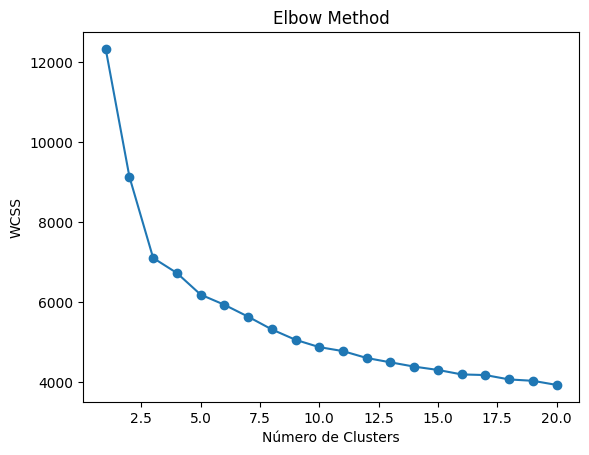

In [69]:
X = final_data[feature_columns]
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do Método do Cotovelo
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

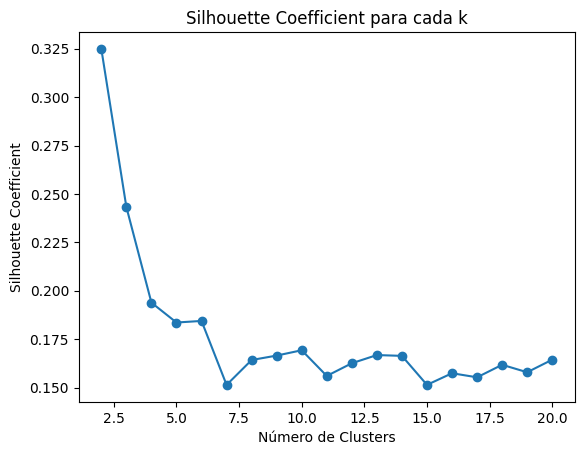

In [71]:
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Coeficiente de Silhueta
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient para cada k')
plt.show()

In [79]:
# Ver resultados top 10 resultados de cada Cluster - k=4
X = final_data[feature_columns]
cluster = final_data.copy()
kmeans = KMeans(n_clusters=4, random_state=42)
cluster['Cluster'] = kmeans.fit_predict(X)
for k in range(4):
    print(f'-------------------------Cluster {k}--------------------------------')
    print(cluster[cluster['Cluster'] == k].sort_values(by='Rating')['Title'][:10])

-------------------------Cluster 0--------------------------------
978     To Gillian on Her 37th Birthday
1670        I Love You, Don't Touch Me!
611                        Carried Away
1469                    She's So Lovely
1038                       Funeral, The
1514            Telling Lies in America
2566                   Brokedown Palace
924                               Bliss
1481                          Star Maps
932                   Last Man Standing
Name: Title, dtype: object
-------------------------Cluster 1--------------------------------
2034                Elstree Calling
2031            Waltzes from Vienna
914         Something to Sing About
3071    With Byrd at the South Pole
916                Moonlight Murder
2572                          Cobra
2935              Bat Whispers, The
3089                Happy Go Lovely
2035               Juno and Paycock
2844                       Ape, The
Name: Title, dtype: object
-------------------------Cluster 2------------------

### DBSCAN

No DBSCAN podemos ver que teve o retorno de 4 clusters, batendo com o resultado que tivemos no K-Means. Também tivemos alguns filmes no cluster -1, que são prováveis outliers. Além disso, é possível ver algumas sequências de filmes no mesmo cluster, um indicativo que estamos detectando realmente alguma similaridade.

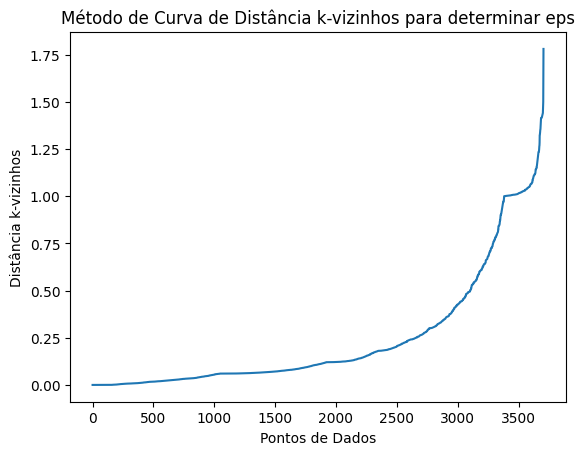

In [80]:
# Determinar o valor de eps usando k-nearest neighbors
X = final_data[feature_columns]
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordenar as distâncias dos k-vizinhos
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância k-vizinhos')
plt.title('Método de Curva de Distância k-vizinhos para determinar eps')
plt.show()

In [89]:
# Aplicar o DBSCAN com eps e min_samples escolhidos
eps = 1
min_samples = 50
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
X = final_data[feature_columns]
cluster = final_data.copy()
cluster['Cluster'] = dbscan.fit_predict(X)
for k in range(-1, 5):
    print(f'-------------------------Cluster {k}--------------------------------')
    print(cluster[cluster['Cluster'] == k].sort_values(by='Rating')['Title'][:10])

-------------------------Cluster -1--------------------------------
3658                                  Uninvited Guest, An
3409    Blood Spattered Bride, The (La Novia Ensangren...
658                                               Windows
696                                         Low Life, The
774                                             Diebinnen
791                                            Lotto Land
1062                                          Get Over It
1287                               Terror in a Texas Town
1078                                    Bloody Child, The
2031                                  Waltzes from Vienna
Name: Title, dtype: object
-------------------------Cluster 0--------------------------------
633                                       Mutters Courage
621     Little Indian, Big City (Un indien dans la ville)
3006                                       Wirey Spindell
2907                 Spring Fever USA (a.k.a. Lauderdale)
1217                      

### Clustering Hierárquico (Agglomerative)